In [1]:
from glob import glob
from os.path import join, basename, splitext
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.transforms import RadiusGraph
from skimage import io
from tqdm import tqdm
from skimage import img_as_float
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import models
import torch.nn as nn
from random import shuffle
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, roc_curve
import os
import pandas as pd
import re
from torch_geometric.data import Data
from models import GraphNet, Preprocess, AttentionPool
import copy

In [2]:
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

def visualize_points(pos, edge_index=None, index=None, edge_weights=None, node_weights=None, show=True, img=None, patch_size=1, fig_text=None, box_color='palegreen'):
    fig = plt.figure(figsize=(torch.max(pos, 0)[0].numpy()[0], torch.max(pos, 0)[0].numpy()[1]))
        # fig_w, fig_h = plt.gcf().get_size_inches()
    if edge_index is not None:
        if edge_weights is None:
            for (src, dst) in edge_index.t().tolist():
                src = pos[src].tolist()
                dst = pos[dst].tolist()
                plt.plot([src[0]*patch_size+int(patch_size/2), dst[0]*patch_size+int(patch_size/2)], [src[1]*patch_size+int(patch_size/2), dst[1]*patch_size+int(patch_size/2)], linewidth=3, color='royalblue')
        else:
            i = 0
            for (s, d) in edge_index.t().tolist():
                src = pos[s].tolist()
                dst = pos[d].tolist()
                plt.plot([src[0]*patch_size+int(patch_size/2), dst[0]*patch_size+int(patch_size/2)], [src[1]*patch_size+int(patch_size/2), dst[1]*patch_size+int(patch_size/2)], linewidth=widths[i]*3, color='royalblue')
                i+=1
    if index is None:
        if node_weights is not None:
            for p, w in zip(pos, node_weights):
                plt.scatter(p[0]*patch_size+int(patch_size/2), p[1]*patch_size+int(patch_size/2), s=w*500, zorder=1000, color='red')
        else:
            plt.scatter(pos[:, 0]*patch_size+int(patch_size/2), pos[:, 1]*patch_size+int(patch_size/2), s=500, zorder=1000, color='red')
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
        plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.gca().invert_yaxis()
    if img is not None:
        im = plt.imread(img)
        plt.imshow(im, alpha=0.5)
    if fig_text is not None:
        plt.figtext(0.5, 0.1, fig_text, ha="center", fontsize=18, bbox={"facecolor":box_color, "alpha":0.5, "pad":5} )
    if show:
        plt.show()
    plt.close()
    return fig
    
def visualize_projection(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
def visualize_grid(pos, color):
    color = color.detach().cpu().numpy()
    pos = pos.detach().cpu().numpy()
    # plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(pos[:, 0], pos[:, 1], s=70, c=color, cmap="Set2")
    plt.gca().invert_yaxis()
    plt.show()
    
def visualize_graph(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [3]:
def read_dataset_to_graph(item, compute_edges=False, weight_func=cosine_similarity, radius=1.5, remove_empty=False):
    feat_arr = item[1]
    pos_arr = np.array(item[0])
    label_arr = np.array(item[4])

    data = Data(x=feat_arr, pos=torch.tensor(pos_arr, dtype=torch.long), y=torch.tensor(label_arr, dtype=torch.long))
    radius_graph = RadiusGraph(radius, loop=True) # 1.5 or 2
    data = radius_graph(data) 
    if compute_edges:
        weights = []
        for i in range(data.edge_index.shape[1]):
            edge = data.edge_index[:, i]
            weight = weight_func( data.x[edge[0]].view(1, -1), data.x[edge[1]].view(1, -1) )
            weights.append(weight)
        # weights = exposure.rescale_intensity( np.vstack(weights).squeeze(), in_range=(0.5, 1), out_range=(0, 1) )
        weights = np.vstack(weights).squeeze()
        data.edge_weight = torch.tensor(weights, dtype=torch.float)
    data.name = item[5]
    return data

def compute_dataset_ref(path, class_codes, ext='png', opt_folder=False):
    classes = glob(join(path, '*'))
    # print(classes) 
    data_list = [] # pos, feats, node labels, node_mask, graph label
    # return None
    for idx, c in enumerate(classes):
        class_name = basename(c)
        if opt_folder:
            regions = glob(join(path, class_name, '*', '*'))
        else:
            regions = glob(join(path, class_name, '*'))
        regions = [x for x in regions if os.path.isdir(x)]
        for region in tqdm(regions):
            try:
                pos_list = []
                feat_list = []
                node_list = []
                mask_list = []
                patches = glob(join(region, '*.'+ext))
                for patch in patches:
                    ### patch pos -> x, y
                    feat = patch
                    masked = False
                    node_label = np.nan

                    x = int(splitext(basename(patch))[0].split('_')[0])
                    y = int(splitext(basename(patch))[0].split('_')[1])
                    pos_list.append((x, y))
                    feat_list.append(feat)  
                    node_list.append(node_label)
                    mask_list.append(masked)
                pos_arr = np.vstack(pos_list)
                feat_arr = feat_list
                node_arr = np.vstack(node_list)
                mask_arr = np.vstack(mask_list)
                graph_label = np.array(class_codes.get(class_name))
                graph_name = region
                data_list.append((pos_arr, feat_arr, node_arr, mask_arr, graph_label, graph_name))
            except:
                print(region)
    return data_list

def sample_weights(graph_train):
    n_sample = []
    for graph in graph_train:
        n_sample.append(graph.y.numpy())
    n_sample = np.asarray(n_sample)
    _, counts = np.unique(n_sample, return_counts=True)
    counts = counts.max() / (10e-3+counts)
    return counts

In [4]:
distributed_codes = {
    'normal': (0, 0),
    'pancreatitis': (0, 1),
    'pdac': (1, 1)
    }

### Compute representations of patches of every ROI, save them as csv files

In [5]:
bag_path = 'data_bags_normalized/TMA'
patch_ext = 'png'
data_list = compute_dataset_ref(bag_path, distributed_codes, ext='png')
train_graph_list = []
for item in tqdm(data_list):
    data = read_dataset_to_graph(item, compute_edges=False, weight_func=cosine_similarity, radius=1.5)
    train_graph_list.append(data)


100%|██████████| 786/786 [00:00<00:00, 2935.02it/s]


### Core level separation

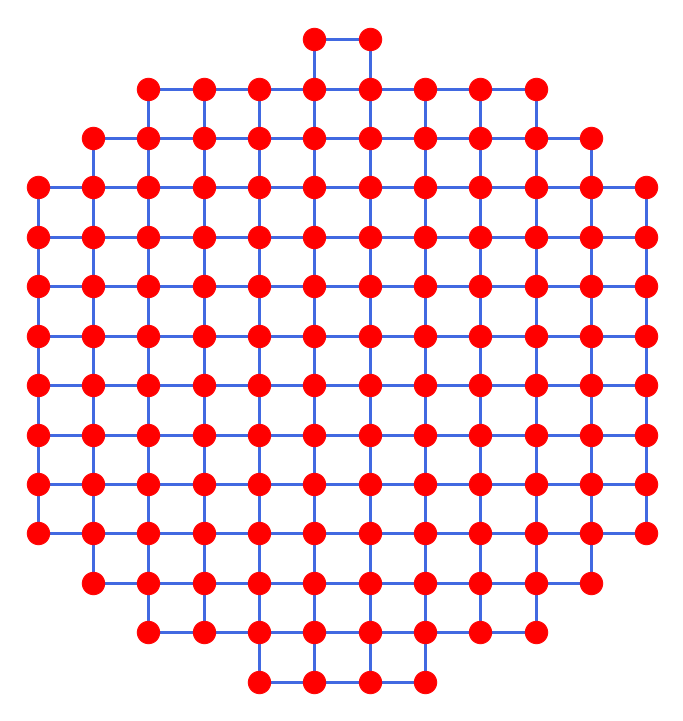

In [6]:
num_fold = 4
while(True):
    weight_mean = max(sample_weights(train_graph_list))
    shuffle(train_graph_list)
    cores_per_chunk = int(len(train_graph_list)/num_fold)
    chunks_data = [train_graph_list[i*cores_per_chunk:(i+1)*cores_per_chunk] for i in range(num_fold)]
    weights = []
    for chunk_data in chunks_data:
        weights.append(sample_weights(chunk_data))
    max_weight = max([max(i) for i in weights])
    if max_weight<weight_mean*1.2: break
fig = visualize_points(train_graph_list[0].pos, edge_index=train_graph_list[0].edge_index)

In [7]:
def multi_label_roc(labels, predictions, pos_label=1):
    num_class = labels.shape[1]
    fprs = []
    tprs = []
    thresholds = []
    thresholds_optimal = []
    aucs = []
    if len(predictions.shape)==1:
        predictions = predictions[:, None]
    for c in range(0, num_class):
        label = labels[:, c]
        prediction = predictions[:, c]
        fpr, tpr, threshold = roc_curve(label, prediction, pos_label=pos_label)
        fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold)
        c_auc = roc_auc_score(label, prediction)
        aucs.append(c_auc)
        thresholds.append(threshold)
        thresholds_optimal.append(threshold_optimal)
    return aucs, thresholds, thresholds_optimal

def optimal_thresh(fpr, tpr, thresholds, p=0):
    loss = (fpr - tpr) - p * tpr / (fpr + tpr + 1)
    idx = np.argmin(loss, axis=0)
    return fpr[idx], tpr[idx], thresholds[idx]

def accuracy_from_thresh(labels, predictions, thresh, priority_func=None): # numpy array, 2D, 2D, 1D
    labels = copy.deepcopy(labels)
    predictions = copy.deepcopy(predictions)
    num_class = labels.shape[1]
    if num_class==1:
        class_prediction_bag = copy.deepcopy(predictions)
        class_prediction_bag[predictions>=thresh[0]] = 1
        class_prediction_bag[predictions<thresh[0]] = 0
        predictions = class_prediction_bag
    else:        
        for i in range(num_class):
            class_prediction_bag = copy.deepcopy(predictions[:, i])
            class_prediction_bag[predictions[:, i]>=thresh[i]] = 1
            class_prediction_bag[predictions[:, i]<thresh[i]] = 0
            predictions[:, i] = class_prediction_bag
    if priority_func is not None:
        predictions = priority_func(predictions)
        labels = priority_func(labels)
        # print(predictions)
        # print(labels)
    # zeros = np.zeros((labels.shape[0], 1))
    # labels = np.argmax(np.concatenate((zeros, labels), 1), 1)
    # predictions = np.argmax(np.concatenate((zeros, predictions), 1), 1)
    acc = balanced_accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return acc, f1

In [24]:
def bag_to_tensors(fnames, img_size=256, img_channel=3):
    batch_img_tensor = torch.zeros((len(fnames), img_channel, img_size, img_size))
    for i, fname in enumerate(fnames):
        img_arr = img_as_float(io.imread(fname)).transpose(2, 1, 0)
        img_tensor = torch.from_numpy(img_arr).float()
        batch_img_tensor[i] = img_tensor
    return batch_img_tensor

def train(loader):
    model.train()
    loss_avg = 0
    count = 0
    for data in tqdm(loader):  
        optimizer.zero_grad()
        x = bag_to_tensors(data.x)  
        out = model(
            x.float().cuda(), 
            edge_index=data.edge_index.cuda(), 
            batch=torch.LongTensor(np.zeros(x.shape[0])).cuda(), 
            edge_weight=data.edge_weight.squeeze().cuda() if data.edge_weight is not None else None,
            )
        out = torch.mean(out, 0).view(1, -1)
        loss = criterion(out, data.y.float().cuda().view(1, -1)) 
        loss.backward()  
        optimizer.step() 
        loss_avg += loss.item()
        count += 1
    return loss_avg / count

def test(loader):
    with torch.no_grad():
        model.eval()
        labels = []
        preds = []
        loss_avg = 0
        for data in tqdm(loader):  
            x = bag_to_tensors(data.x)  
            out = model(
                x.float().cuda(), 
                edge_index=data.edge_index.long().cuda(), 
                batch=torch.LongTensor(np.zeros(x.shape[0])).cuda(),
                edge_weight=data.edge_weight.squeeze().cuda() if data.edge_weight is not None else None,
                )  
            out = torch.mean(out, 0).view(1, -1)
            loss = criterion(out, data.y.float().cuda().view(1, -1)) 
            preds.append(torch.sigmoid(out).cpu().numpy().squeeze())
            labels.append(data.y.numpy().squeeze())
            loss_avg += loss.item()
        preds = np.array(preds)
        labels = np.array(labels)
        aucs, thresholds, thresholds_optimal = multi_label_roc(labels, preds)
        def priority_func(pred):
            codes = []
            for x in pred:
                if x[0]==1: code = 2
                if x[0]==0 and x[1]==0: code = 0
                if x[0]==0 and x[1]==1: code = 1
                codes.append(code)
            return codes
        # priority_func = None
        acc, f1 = accuracy_from_thresh(labels, preds, thresholds_optimal, priority_func)
    return loss_avg / len(loader), acc, f1, aucs, thresholds_optimal 

In [25]:
num_epochs = 150
weight_decay = 0.0005
weights_name = 'MLP_TMA_Distributed_Backbone'
weights_path = 'weights_cv'
os.makedirs('weights_cv', exist_ok=True)
cnn = models.resnet18(pretrained=True)
cnn.fc = nn.Linear(512, 2)
model = GraphNet(
        in_channels=512, 
        out_channels=2, 
        hidden_channels=512, 
        gcn_layer='GCN', 
        graph_pool='mean', 
        drop_p0=0.0,
        drop_p1=0.25, 
        preprocess=Preprocess(hidden_channels=512, out_channels=2),
        )
model = Preprocess(out_channels=512, out_class=2, head=False, backbone=cnn)
lr = 0.0005
model = model.cuda()
model

Preprocess(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [26]:
torch.save(model.state_dict(), os.path.join(weights_path, 'init_distributed_backbone.pth'))
for i in range(num_fold):
    model.load_state_dict(torch.load(os.path.join(weights_path, 'init_distributed_backbone.pth')))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, 0.00001)
    optimal_score = 0
    print(f'Running cross-validation fold: {i:02d}')
    graph_train  = []
    graph_test = []
    for k in range(num_fold):
        if k != i: graph_train += chunks_data[k]
        else: graph_test = chunks_data[k]
    n_sample = []
    for graph in graph_train:
        n_sample.append(graph.y.numpy())
    n_sample = np.asarray(n_sample)
    counts = np.count_nonzero(n_sample, axis=0)
    counts = counts.max() / counts
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.from_numpy(counts)).cuda()   
    # criterion = nn.MSELoss()
    for epoch in range(1, num_epochs):
        shuffle(graph_train)
        train(graph_train)
        scheduler.step()    
        train_loss, train_acc, _, _, _ = test(graph_train)
        test_loss, test_acc, avg_prc, aucs, thresh = test(graph_test)
        log_msg = f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test f1: {avg_prc:.4f}' + ', AUC: ' + '|'.join('class-{}>>{}'.format(*k) for k in enumerate(aucs))
        print(log_msg)
        sum_metrics = (avg_prc+test_acc+sum(aucs))/3
        if sum_metrics > optimal_score:
            optimal_score = sum_metrics
            os.makedirs(weights_path, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(weights_path, f'{weights_name}_fold{i:02d}.pth'))
            print('Saved model!')
            print('Best thresholds ===>>> '+ '|'.join('class-{}>>{}'.format(*k) for k in enumerate(thresh)))
            with open(os.path.join(weights_path, f'{weights_name}_fold{i:02d}.txt'), "w") as text_file:
                print('Best thresholds ===>>> '+ '|'.join('class-{}>>{}'.format(*k) for k in enumerate(thresh))+'|||'+log_msg, file=text_file)

Running cross-validation fold: 00


 26%|██▌       | 150/588 [01:46<05:08,  1.42it/s]

### Read result summary

In [11]:
log_files = glob(os.path.join(weights_path, f'{weights_name}_*.txt'))
results = []
for log_file in log_files:
    with open(log_file) as text_file:
        lines = text_file.readlines()[0]
        results.append([float(i) for i in re.findall("\d+\.\d+", lines)[3:]])
results = np.vstack(results).mean(0)
print(f'Cross-validation results of {weights_name}: Acc {results[2]}, f1 {results[3]}, AUC PDAC {results[4]}, AUC CP {results[5]}')

Cross-validation results of GCN_TMA_Distributed: Acc 0.8638, f1 0.882275, AUC PDAC 0.9817209148686096, AUC CP 0.9548312861924901
